# Temporal Fusion Transformer

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns

import torch
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# tesnorboard
import tensorflow as tf
import tensorboard as tb

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# 1. Data load

In [2]:
os.chdir('../..')

In [3]:
os.getcwd()

'c:\\Users\\maxim\\Documents\\GitHub\\gold-forecast'

In [4]:
df = pd.read_csv('data/data_nominal_clean.csv', sep=';', parse_dates=['date'])
df.head()

,date,Gold,CrudeOil,S&P500,FTSE250
0,1986-01-02,326.30,25.56,209.59,1417.26
1,1986-01-03,326.75,26.00,210.88,1424.61
2,1986-01-06,328.00,26.53,210.65,1430.96
3,1986-01-07,330.00,25.85,213.80,1421.22
4,1986-01-08,332.60,25.87,207.97,1408.79


<AxesSubplot: xlabel='y(t)', ylabel='y(t + 20)'>

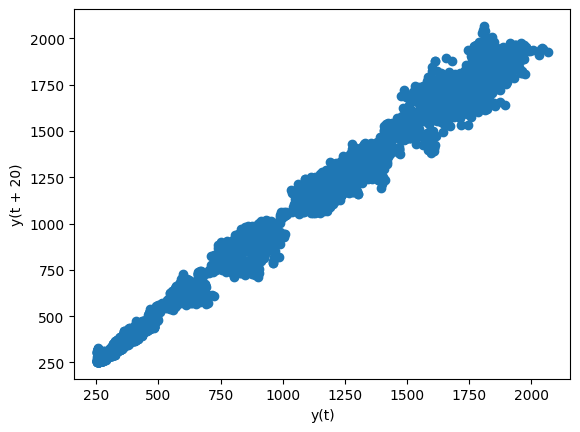

In [5]:
lag_plot(df.Gold, lag=20)

# 2. Preparing data for the model

Necessary manipulations and creations of new variables

In [6]:
df[['CrudeOil_lag','Gold_lag','S&P500_lag','FTSE250_lag']] = df[['CrudeOil','Gold','S&P500','FTSE250']].shift(20)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df

,date,Gold,CrudeOil,S&P500,FTSE250,CrudeOil_lag,Gold_lag,S&P500_lag,FTSE250_lag
0,1986-01-30,358.00,19.58,209.33,1437.46,25.56,326.30,209.59,1417.26
1,1986-01-31,350.50,18.95,211.78,1449.47,26.00,326.75,210.88,1424.61
2,1986-02-03,347.30,17.42,213.96,1444.67,26.53,328.00,210.65,1430.96
3,1986-02-04,338.60,15.58,212.79,1444.24,25.85,330.00,213.80,1421.22
4,1986-02-05,337.30,16.28,212.96,1448.76,25.87,332.60,207.97,1408.79
...,...,...,...,...,...,...,...,...,...
9124,2022-12-30,1813.75,80.16,3839.50,18853.00,80.48,1753.50,4080.11,19163.33
9125,2023-01-03,1843.25,76.87,3824.14,19134.34,81.06,1803.15,4076.57,19409.42
9126,2023-01-04,1857.30,72.82,3852.97,19391.07,79.86,1784.75,4071.70,19363.28
9127,2023-01-05,1834.00,73.61,3808.10,19463.43,76.83,1776.80,3998.84,19329.58


In [7]:
dataset = df.drop(['CrudeOil', 'S&P500', 'FTSE250'], axis=1)
dataset['grp'] = 1 # TFT requires group, adding one group for all since this only has one
dataset['time_idx'] = dataset.reset_index(drop=True).index # creating time index - basically date that is digestible for TFT
dataset

,date,Gold,CrudeOil_lag,Gold_lag,S&P500_lag,FTSE250_lag,grp,time_idx
0,1986-01-30,358.00,25.56,326.30,209.59,1417.26,1,0
1,1986-01-31,350.50,26.00,326.75,210.88,1424.61,1,1
2,1986-02-03,347.30,26.53,328.00,210.65,1430.96,1,2
3,1986-02-04,338.60,25.85,330.00,213.80,1421.22,1,3
4,1986-02-05,337.30,25.87,332.60,207.97,1408.79,1,4
...,...,...,...,...,...,...,...,...
9124,2022-12-30,1813.75,80.48,1753.50,4080.11,19163.33,1,9124
9125,2023-01-03,1843.25,81.06,1803.15,4076.57,19409.42,1,9125
9126,2023-01-04,1857.30,79.86,1784.75,4071.70,19363.28,1,9126
9127,2023-01-05,1834.00,76.83,1776.80,3998.84,19329.58,1,9127


In [8]:
dataset.dtypes

date            datetime64[ns]
Gold                   float64
CrudeOil_lag           float64
Gold_lag               float64
S&P500_lag             float64
FTSE250_lag            float64
grp                      int64
time_idx                 int64
dtype: object

In [9]:
max_prediction_length = 20 # We will predict last 20 days 
max_encoder_length = max_prediction_length*4
training_cutoff = dataset["time_idx"].max() - max_prediction_length #validation on last 20 days

In [10]:
training_cutoff

9108

Creating TimeSeriesDataset for training and validation, specifying all variables and additional arguments for the model

In [11]:
training = TimeSeriesDataSet(
    dataset[lambda x: x.time_idx<=training_cutoff],
    target="Gold",
    group_ids= ["grp"],
    time_idx="time_idx",
    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["Gold_lag","CrudeOil_lag","S&P500_lag","FTSE250_lag","time_idx"],
    #time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(
        groups=["grp"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    dataset,
    predict=True,
    stop_randomization=True
)

Training and validation dataloaders

In [12]:
batch_size = 32

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10, num_workers=8)

#load the first batch
x, y = next(iter(train_dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[1266.1500, 1269.1500, 1268.7000,  ..., 1205.5500, 1219.7500,
         1229.9500],
        [ 543.5000,  545.8000,  556.5000,  ...,  623.0000,  626.0000,
          631.5000],
        [1144.7500, 1143.0000, 1133.7500,  ..., 1192.5000, 1205.5000,
         1213.0000],
        ...,
        [ 317.5500,  319.2500,  322.5000,  ...,  343.9500,  349.3000,
          347.2000],
        [ 387.2500,  387.4500,  389.0000,  ...,  375.6500,  374.5000,
          374.5000],
        [ 870.5000,  877.0000,  888.7500,  ...,  956.0000,  945.0000,
          942.7500]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


tensor([[1230.7000, 1

# 3. Modeling
## A) Baseline model

In [13]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


36.40245819091797

## B) Temporal Fusion Transformer
Specifying model parameters

In [14]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs", log_graph=True)  

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto', 
    devices='auto',
    enable_model_summary=True,
    gradient_clip_val=0.2,
    #fast_dev_run=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    )

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=4,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=4,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=3,
    optimizer='Ranger', 
    reduce_on_plateau_patience=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


Fitting the model

In [15]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
    )


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 72    
4  | static_variable_selection          | VariableSelectionNetwork        | 378   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 802   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 802   
7  | static_context_variable_selection  | GatedResidualNetwork            | 88    
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 88    
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 88  

Epoch 0: 100%|██████████| 284/284 [02:16<00:00,  2.08it/s, v_num=3, train_loss_step=71.30, val_loss=167.0, train_loss_epoch=246.0]

Metric val_loss improved. New best score: 167.282


Epoch 1: 100%|██████████| 284/284 [02:28<00:00,  1.91it/s, v_num=3, train_loss_step=31.10, val_loss=30.40, train_loss_epoch=38.60]

Metric val_loss improved by 136.845 >= min_delta = 0.0001. New best score: 30.438


Epoch 2: 100%|██████████| 284/284 [02:50<00:00,  1.67it/s, v_num=3, train_loss_step=19.00, val_loss=28.40, train_loss_epoch=22.70]

Metric val_loss improved by 2.015 >= min_delta = 0.0001. New best score: 28.423


Epoch 3: 100%|██████████| 284/284 [02:20<00:00,  2.02it/s, v_num=3, train_loss_step=12.70, val_loss=21.00, train_loss_epoch=19.30]

Metric val_loss improved by 7.456 >= min_delta = 0.0001. New best score: 20.967


Epoch 6: 100%|██████████| 284/284 [02:51<00:00,  1.66it/s, v_num=3, train_loss_step=12.60, val_loss=18.90, train_loss_epoch=16.50]

Metric val_loss improved by 2.067 >= min_delta = 0.0001. New best score: 18.900


Epoch 7: 100%|██████████| 284/284 [02:54<00:00,  1.63it/s, v_num=3, train_loss_step=14.40, val_loss=17.70, train_loss_epoch=15.80]

Metric val_loss improved by 1.184 >= min_delta = 0.0001. New best score: 17.716


Epoch 8: 100%|██████████| 284/284 [02:44<00:00,  1.73it/s, v_num=3, train_loss_step=16.80, val_loss=16.70, train_loss_epoch=15.00]

Metric val_loss improved by 1.015 >= min_delta = 0.0001. New best score: 16.701


Epoch 10: 100%|██████████| 284/284 [02:30<00:00,  1.89it/s, v_num=3, train_loss_step=14.20, val_loss=16.50, train_loss_epoch=14.50]

Metric val_loss improved by 0.201 >= min_delta = 0.0001. New best score: 16.499


Epoch 13: 100%|██████████| 284/284 [02:44<00:00,  1.73it/s, v_num=3, train_loss_step=12.70, val_loss=28.80, train_loss_epoch=14.30]

Monitored metric val_loss did not improve in the last 3 records. Best score: 16.499. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 284/284 [02:45<00:00,  1.72it/s, v_num=3, train_loss_step=12.70, val_loss=28.80, train_loss_epoch=14.30]


# 4. Plotting and metrics
Loading the model

In [16]:
# best_model_path = trainer.checkpoint_callback.on_load_checkpoint
# print(best_model_path) # this didnt work :(
best_tft = TemporalFusionTransformer.load_from_checkpoint(r'lightning_logs\lightning_logs\version_3\checkpoints\epoch=10-step=3124.ckpt', strict=False)

## A) Getting predictions and plotting them for variables

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(valu

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Gold_center': <Figure size 1000x500 with 2 Axes>,
 'Gold_scale': <Figure size 1000x500 with 2 Axes>,
 'Gold_lag': <Figure size 1000x500 with 2 Axes>,
 'CrudeOil_lag': <Figure size 1000x500 with 2 Axes>,
 'S&P500_lag': <Figure size 1000x500 with 2 Axes>,
 'FTSE250_lag': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>}

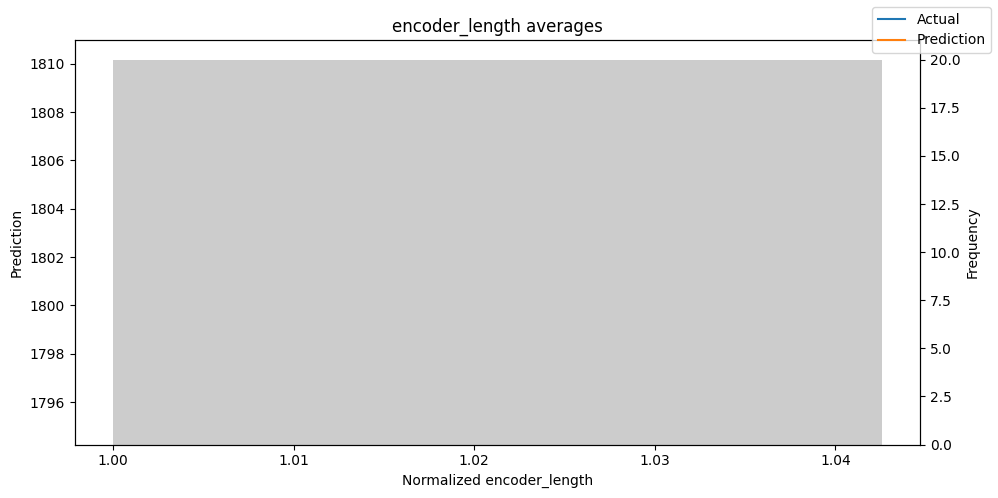

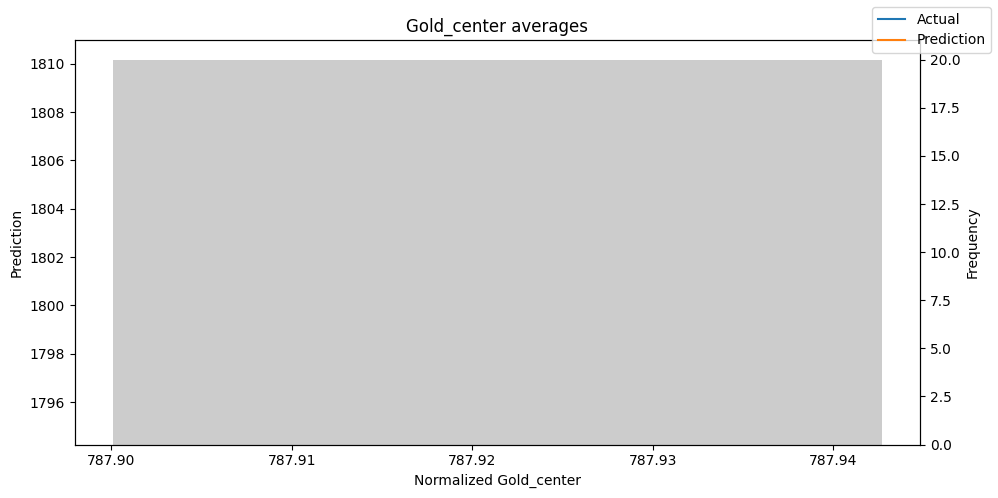

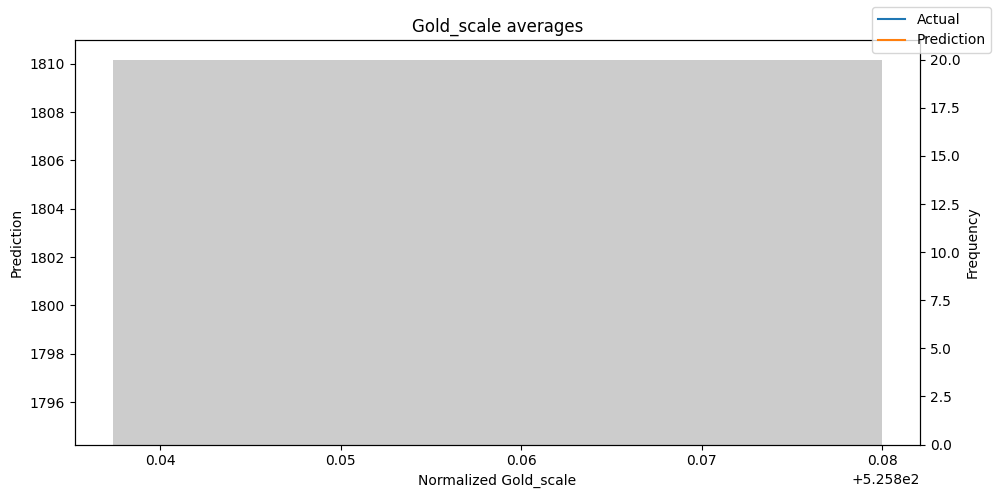

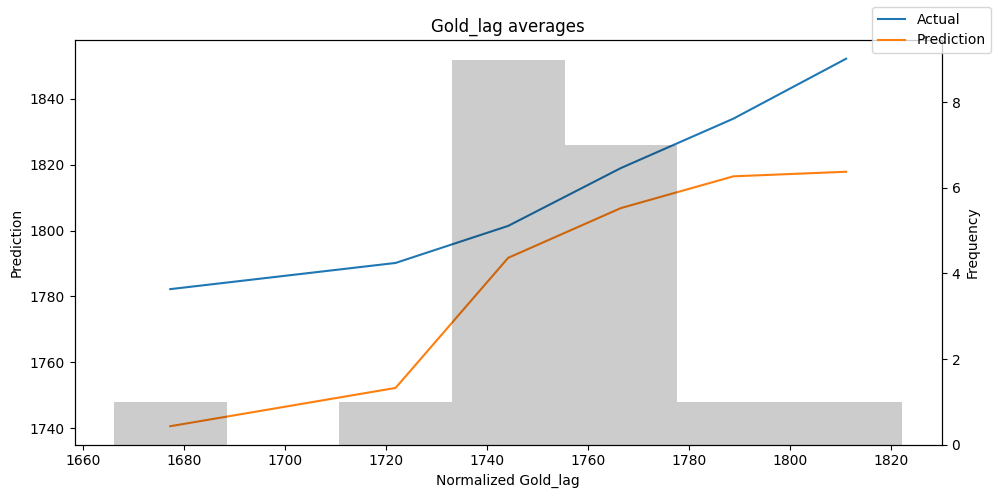

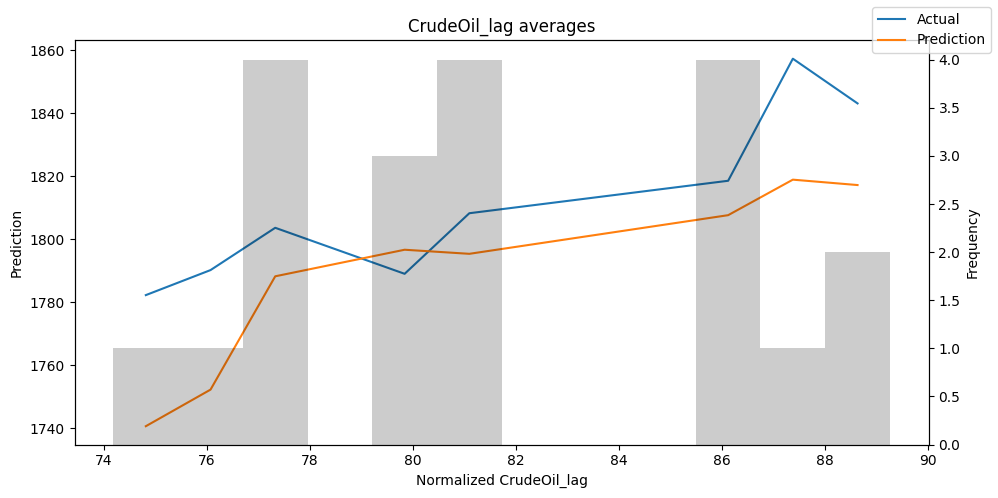

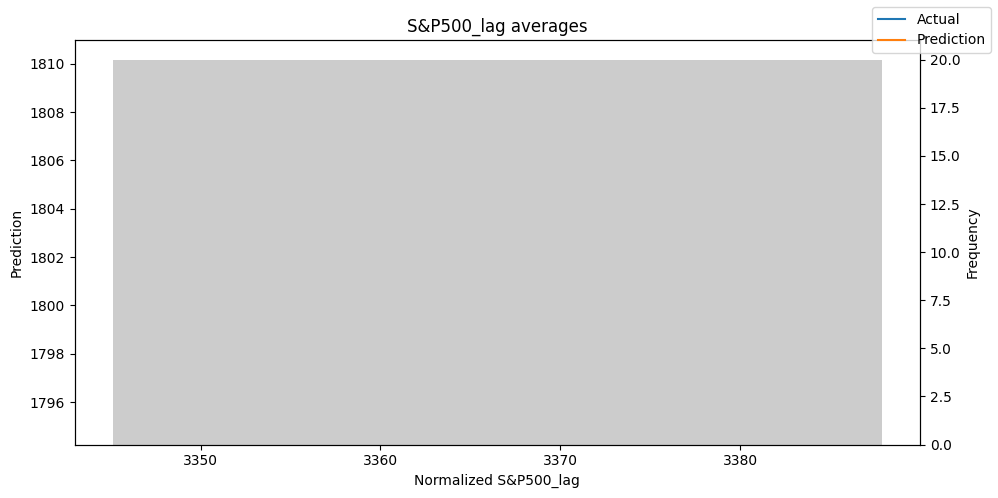

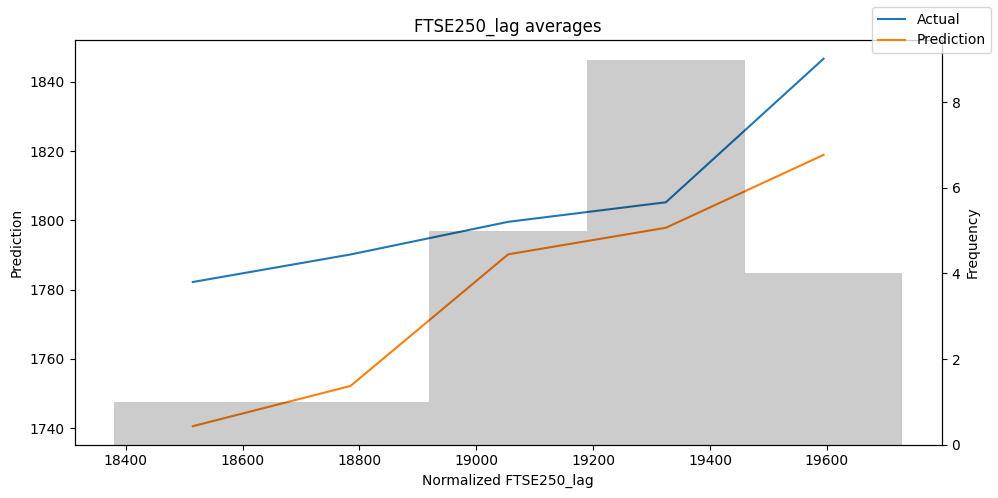

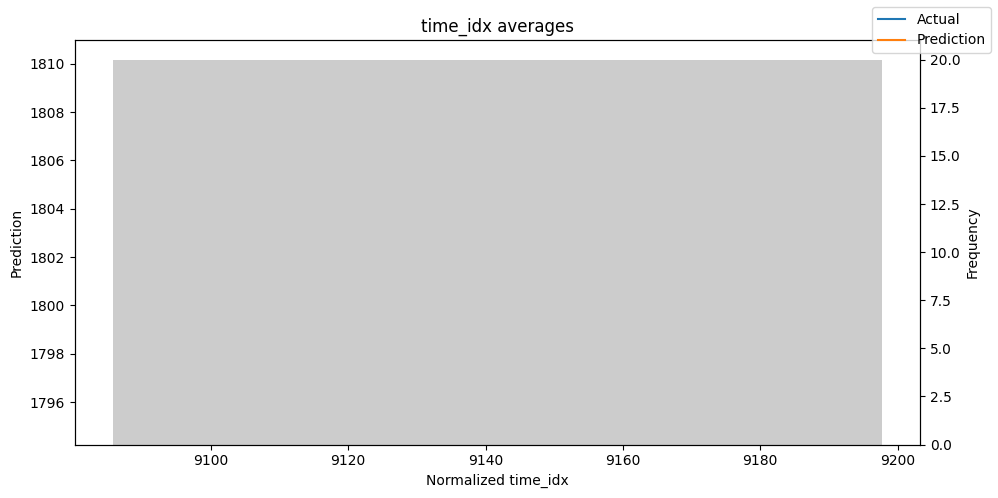

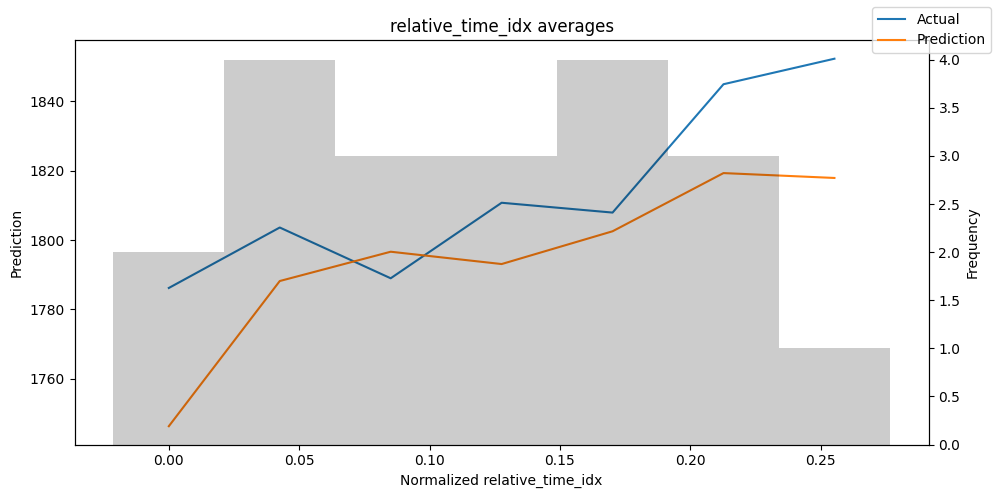

In [17]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [18]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(17.6272)

In [19]:
MAPE()(predictions.output, predictions.y)

tensor(0.0097)

In [20]:
# MASE()(predictions.output, predictions.y)

In [21]:
RMSE()(predictions.output, predictions.y)

tensor(22.0504)

In [22]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

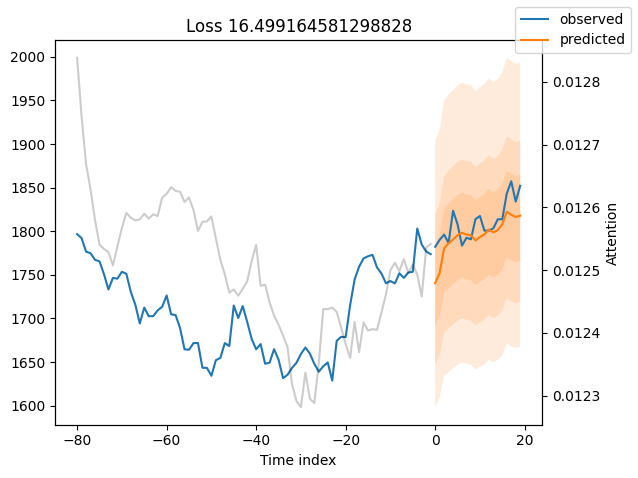

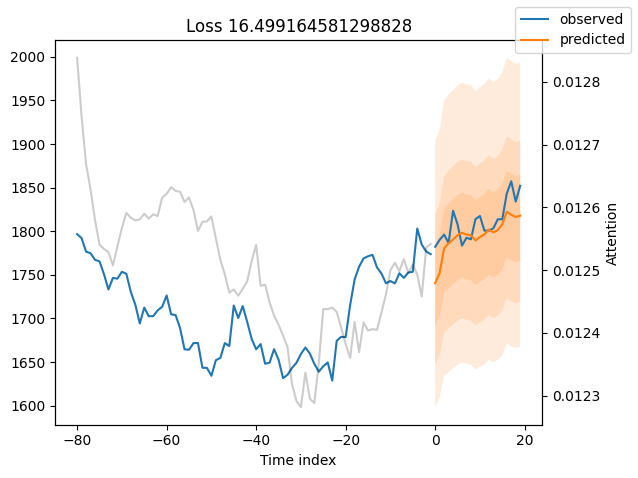

In [23]:
idx = 0
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)

## B) Interpretation plots

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

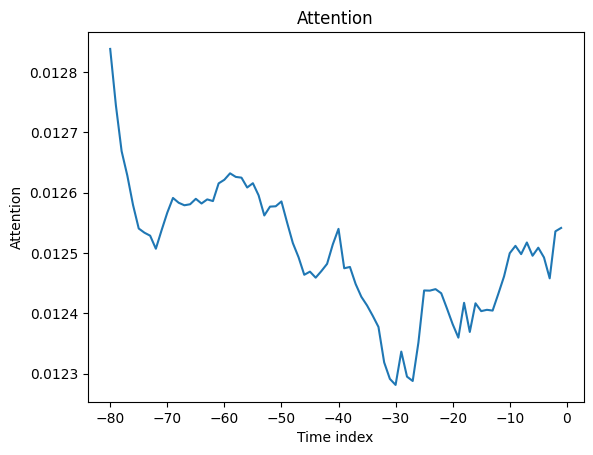

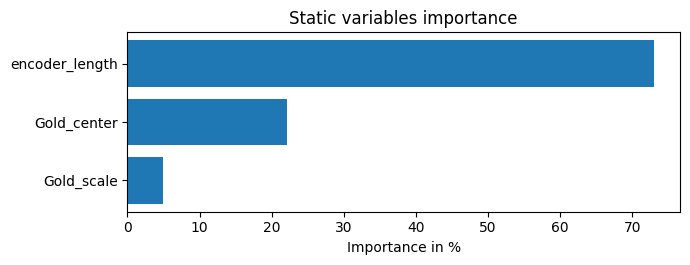

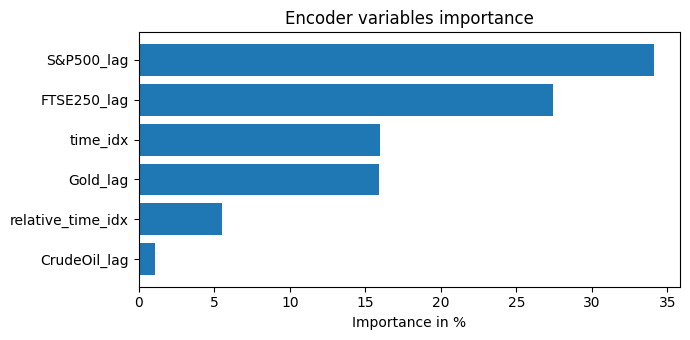

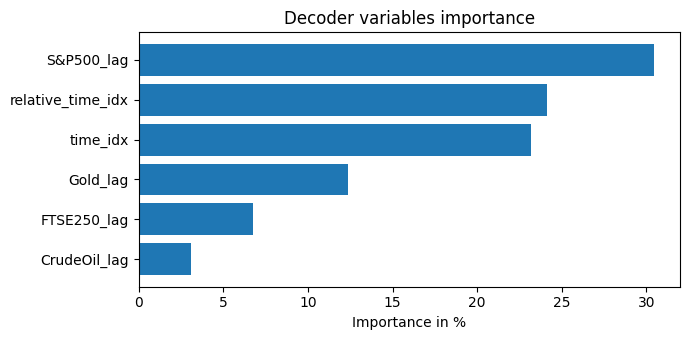

In [24]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)